# Initial Satelitte Data retrieval

The following dataset was gathered from [NASA FIRMs website](https://firms.modaps.eosdis.nasa.gov/download/) and encases all fire anomalies between 2015 and 2019 in Northern California. The initial data cleaning that follows will narrow down the scope of our search to Northern California using the proper longitute and latitude ranges comprising a square area of approximately 70,000 km^2. All anomalies contained in the final dataframe should be over land, and also with a confidence rating of over 75%. This confidence rating is a measurement of how sure that the satellite succesfully detected a fire anomaly.

The resulting dataframe we will use to query the Google Static Maps API to retrieve satellite images of areas of northern California that have experienced fires over the last 5 years. We will then try to use these images to train a Convolutional Neural Network that is able to determine if an area has experienced a fire event, or it has not.

# Importing Neccesary Libraries and Packages


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import random

import urllib.request
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import os

The following csv's were downloaded from https://firms.modaps.eosdis.nasa.gov/country/. This archive contains all fire anomalies recorded by the Modis instrument satellites over the planet earth. To get each relevant dataset I merely selected the year, and the country, in this case the United States, in which our target area Northern California is located. Thus each dataset you see below contains all the fire anomalies recorded over the US for each year respective year.

In [3]:
df_2015 = pd.read_csv('../data/modis_2015_United_States.csv')
df_2016 = pd.read_csv('../data/modis_2016_United_States.csv')
df_2017 = pd.read_csv('../data/modis_2017_United_States.csv')
df_2018 = pd.read_csv('../data/modis_2018_United_States.csv')
df_2019 = pd.read_csv('../data/modis_2019_United_States.csv')

Let's condense all of our dataframes into a single one so we can perform the proper masks in 2 or 3 fell strokes to get the fire instances from our target area.

In [4]:
frames = [df_2015, df_2016, df_2017, df_2018, df_2019]
pre_final = pd.concat(frames)

In [5]:
pre_final.shape

(643545, 15)

In [6]:
pre_final.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,19.4104,-155.2771,306.4,1.1,1.1,2015-01-01,830,Terra,MODIS,68,6.2,284.0,12.1,N,2
1,19.4425,-155.0047,324.1,1.1,1.0,2015-01-01,830,Terra,MODIS,100,6.2,286.0,29.0,N,2
2,19.4601,-154.9925,313.0,1.1,1.0,2015-01-01,830,Terra,MODIS,86,6.2,288.0,16.7,N,2
3,19.4087,-155.2876,309.8,1.1,1.1,2015-01-01,830,Terra,MODIS,78,6.2,284.0,14.8,N,2
4,41.6333,-87.1361,301.0,1.9,1.3,2015-01-01,1717,Terra,MODIS,33,6.2,270.7,22.7,D,2


## Data Filtering
The conglorerate dataset above contains all the fire instances across the United Stated between 2015-2019, I wanted to shift my focus to Northern California. Let me show you how I did so.

In [7]:
#mask to limit our dataset to latitudes between 38.0881 and 40.8366

pre_final_2 = pre_final[(pre_final['latitude'] >= 38.0881) & (pre_final['latitude'] <= 40.8336)] 

In [8]:
#mask to limit our dataset to longitudes between -123.1208 & -120.2933
pre_final_3 = pre_final_2[(pre_final_2['longitude'] >= -123.1208) & (pre_final_2['longitude'] <= -120.2933)]

In [9]:
#mask to only give us fire instances with a given confidence level from the Satellite of 75%
final_wf_df = pre_final_3[(pre_final_3['confidence'] >= 75)]

In [10]:
final_wf_df.shape


(10896, 15)

Our dataset after cleaning has 10,896 images, this should be more than enough instances to feed the model.

In [11]:
final_wf_df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
383,38.8901,-122.9681,322.2,1.3,1.1,2015-01-07,2137,Aqua,MODIS,81,6.2,294.9,28.3,D,0
384,38.8884,-122.9837,321.4,1.3,1.1,2015-01-07,2137,Aqua,MODIS,81,6.2,293.4,26.8,D,0
851,39.1576,-120.6349,322.6,3.5,1.8,2015-01-12,2156,Aqua,MODIS,82,6.2,278.8,140.0,D,0
909,39.9387,-120.7503,327.4,1.1,1.0,2015-01-13,2101,Aqua,MODIS,85,6.2,276.4,34.5,D,0
911,39.9340,-120.7438,332.2,1.1,1.0,2015-01-13,2101,Aqua,MODIS,88,6.2,277.7,40.3,D,0


In [12]:
final_wf_df.rename(columns={'latitude':'lat', 
                         'longitude':'lon',
                         'acq_date':'date'}, inplace = True) #renaming to reduce my own confusion when we go to query the google api
                                                            

### All Fire Instances captured from our cleaned MODIS Thermal Anomaly Data Set.

![Summary of Fire Instances in Northern California between 2015 and 2019](../reports/visualizations/composite_fire_map_2015_to_2019_v2.png)

# Setting up for our Google Static Map API Query

Below you will notice I have reduced the final dataframe to include the data, latitude, and longitude components. And then the creation of a new column, centered, which contains a combined tuple of latitude and longitude for a given fire instance. You may also notice when we go to query the google api that an input for the date is not included. This is because the Google static map api does not allow you to retrieve historical satellite images, only its most recent image for the given area queried. At the beginning of this project my intention was to query the NASA Earth API to retrieve historical satellite images of the day of the fire instance. But the images retrieved were problematic and of low resolution, and thus not very valuable when it comes to training a Convolutional Neural Network.

However I have decided to keep the dates of fire instances included for future work when this obstacle is overcome. The corresponding issues of training a CNN model with non historical satellite images for the day of recorded fire instances will be addressed in the attached ReadMe. Also what this means for model interpretability will also be addressed.

In [13]:
df_fire_final= final_wf_df[['date','lat','lon']] 

In [14]:
#The data for our columns must be converted to strings for when we go to query our api.
# our center column is created that creates a combined latitude, longitude tuple.

df_fire_final['date'] = df_fire_final['date'].astype(str) 
df_fire_final['lon'] = df_fire_final['lon'].astype(str) 
df_fire_final['lat'] = df_fire_final['lat'].astype(str)
df_fire_final['center']= df_fire_final[['lat','lon']].agg(','.join, axis = 1)

In [15]:
df_fire_final.head()

,date,lat,lon,center
383,2015-01-07,38.8901,-122.9681,"38.8901,-122.9681"
384,2015-01-07,38.8884,-122.9837,"38.8884,-122.9837"
851,2015-01-12,39.1576,-120.6349,"39.1576,-120.6349"
909,2015-01-13,39.9387,-120.7503,"39.9387,-120.7503"
911,2015-01-13,39.934,-120.7438,"39.934,-120.7438"


In [16]:
df_fire_final.dtypes #making sure all columns contain object types for we go to retrieve from the google api

date      object
lat       object
lon       object
center    object
dtype: object

## Retrieving Satellite Imagery for Fire-Areas
We now have all the revelant information that we need when we go to retrieve the satellite images of the areas that have experienced fire instances.

## Setting up image download request with Google API.

In [17]:
img_size = '350x350' # 

img_format = 'jpg'

map_scale = '1' # For scale parameter. 

maptype = 'satellite' #

zoom = '15' 

In [18]:
key = open('../google_api/google_key.txt', 'r').read() #google api key.

In [19]:
a = 'https://maps.googleapis.com/maps/api/staticmap?' # Base
b = 'center=' # Center, for our centered longitude and latitude tuple 
# Enter df_fire_final['center']
c = '&zoom=' # Zoom
# Enter Zoom
d = '&maptype=satellite' # Map type = satellite imagery

e = '&size=' # Image Size

f = '&key='
# Enter key

# Creating the URL:
url1 = a + b
url2 = c + zoom + d + e + img_size + f + key


## Looping thru our request
To get all of our images I needed to make a loop that went thru each row of the df_fire_final dataset, and retrieved the centered longitude and latitude tuple to give me the image for a given fire instance. You'll notice that this bar is only halfway completed through. That was more to do with the fact that it costs money to make so many requests through google, and being that this was a replication, it was not worth running thru this entire process again. 


In [26]:
i = 0 
with tqdm(total=df_fire_final.shape[0]) as pbar: #this gives us our progress bar below, and lets us know when we have
                                                    #downloaded all of our images

    for index, row in df_fire_final.iterrows(): 
        url= url1 + row['center'] + url2
        urllib.request.urlretrieve(url, os.path.join(os.path.pardir,'images','fire_images',)\
                                    + row['center']
                                    +'.jpg')
        pbar.update(1)

## Composite Image of all the fire instances collected between 2015 and 2019

![composite map](../reports/visualizations/composite_fire_map_2015_to_2019_v2.png)

## Retrieving the non-fire areas.

To retrieve the latitude and longitude coordinates coordinates for non fire areas I used the df_fire_final dataframe to randomly generate coordinates over the same grid that we pulled our fire area coordinates from. Because there is a good chance we will randomly select non fire areas that are actually fire areas, we are going to go thru later and drop these instances, to avoid duplicates in our training, test, and validation data.

In [20]:
non_fire_size= 10000

df_fire_final['lat'] = df_fire_final.lat.astype(float) #to get randomized latitude and longitude coordinates
                                                        #we need to convert back to floats
df_fire_final['lon'] = df_fire_final.lon.astype(float)

new_lat = np.random.uniform(low= min(df_fire_final.lat),
                            high = max(df_fire_final.lat),  #randomizing our new coordinates between the square area we
                            size= (non_fire_size,))         # retrieved the wildfire images from

new_lon = np.random.uniform(low = min(df_fire_final.lon),
                            high = max(df_fire_final.lon),
                            size=(non_fire_size,))

new_coordinates= {'lat':new_lat,'lon':new_lon}

df_non_fire = pd.DataFrame(data = new_coordinates)


df_non_fire['lat'] = df_non_fire['lat'].astype(str)  #converting our new coordinates to string so we can use them when we
df_non_fire['lon'] = df_non_fire['lon'].astype(str)  #call on our API
df_non_fire['center'] = df_non_fire[['lat', 'lon']].agg(','.join, axis = 1) #column containing center
                                                                            #tuple of generated latitude 
                                                                            #and longitude



df_fire_final['lat'] = df_fire_final.lat.astype(str)
df_fire_final['lon'] = df_fire_final.lon.astype(str)

df_non_fire.head()

,lat,lon,center
0,40.06690741592873,-120.47901350348768,"40.06690741592873,-120.47901350348768"
1,38.17979820376051,-121.08361211716664,"38.17979820376051,-121.08361211716664"
2,39.233175090197236,-120.33541678034237,"39.233175090197236,-120.33541678034237"
3,40.0874595454609,-121.55360363211328,"40.0874595454609,-121.55360363211328"
4,40.31752714656348,-122.32383252662589,"40.31752714656348,-122.32383252662589"


In [21]:
os.path.join(os.path.pardir,'images','non_fire',) #File path to store our non_fire satellite images.

'..\\images\\non_fire'

## Query for non-fire area images

In [ ]:
#i = 0 
with tqdm(total=df_non_fire.shape[0]) as pbar:

    for index, row in df_non_fire.iterrows():
        url= url1 + row['center'] + url2
        urllib.request.urlretrieve(url, os.path.join(os.path.pardir,'images','non_fire',)\
                                    + row['center']
                                    +'.jpg')
            
        pbar.update(1)

## Importing Neccesary Packages for modeling

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

### Retrieving images from their respective folders.

Here I'm going to make a function that retrieves fire and non fire class images and labels them according to which folder they reside in the directory. This will later serve to provide a label on the image that the Convolutional Neural Network and train on. 

In [23]:
labels = ['fire', 'no_fire']
img_size = 150 #here we begin to define our image size as 150 X 150. Pictures with many pixels take longer time to process.


def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

It should be noted that the variables below each contain a list of images. These images had to be split into train, test, and validation folders respectively. It was done the old fashion way...Dragging and Dropping. Respective ratios were honored when it came to how many images were kept to be kept in a given folder type.

In [24]:
train = get_training_data('../images/wf_images/train') 
test = get_training_data('../images/wf_images/test')
val = get_training_data('../images/wf_images/val')

## Classification balance for training data.

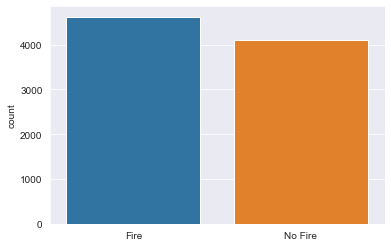

In [28]:
classification_check = []
for i in train:
    if(i[1]==0):
        classification_check.append('Fire')
    else:
        classification_check.append('No Fire')
sns.set_style('darkgrid')
sns.countplot(classification_check)

## Classification Balance for validation data.

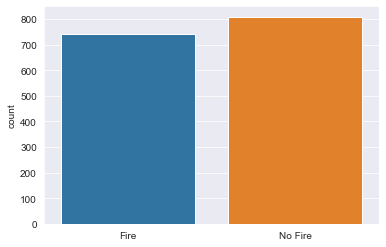

In [29]:
class_check_2 = []
for i in val:
    if(i[1]==0):
        class_check_2.append('Fire')
    else:
        class_check_2.append('No Fire')
sns.set_style('darkgrid')
sns.countplot(class_check_2)

# Example of fire-area vs. non-fire area.

Text(0.5, 1.0, 'no_fire')

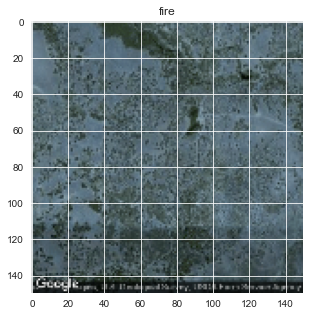

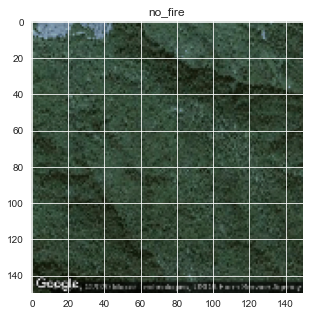

In [30]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

# Data Preprocessing

Next we need to go thru each respective folder and make sure that each image has the appropriate fire area or non-fire area class label attached to it. Next I went thru each data array and normalized the RGB image values to range from 0-1. This helps when we are running the Convolutional Neural Network, and ensure that the model will converge faster. Lastly I reshaped the array so it could be properly pushed through the Convolutional Neural Network. 

## Step 1.) Image Labeling

In [31]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

## Step 2.) Normalizing the Data

In [32]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

## Step 3.) Reshaping the Data

In [33]:
# reshaping data array for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

# The Convolutional Neural Network

For my image classification I decided to use a Convolutional Neural Network. It has an input layer, followed by several convolutional and pooling layers. Each Layer has a relu activation. Relu stands for rectified linear activation function, which is a piecewise linear function that will output the input directly if it is positive, otherwise it will be zero. This prevents our output being stuck between a zero or 1 value. These convolutional and pooling laters converge onto a dense layer that connects each input node to each output node. Finally this layer converges onto a single classification neuron that is sigmoid activated. Sigmoid activation is used for problems like ours where we are making a binary classification: is the image shown a fire area, or a non-fire area.

In [41]:
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show

# First Runner Up
I included this model to show the difficulty in getting good results. 

In [43]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3) , strides =1, padding ='same', activation = 'relu', input_shape = (150,150,3)))
model_2.add(MaxPool2D((2,2) , strides =2, padding ='same'))
model_2.add(Conv2D(64, (3,3), strides =1, padding = 'same', activation = 'relu'))
model_2.add(Dropout(0.1))
model_2.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model_2.add(Conv2D(64, (3,3), strides =1, padding = 'same', activation = 'relu'))
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_2.add(Flatten())
model_2.add(Dense(units = 128 , activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(units = 1 , activation = 'sigmoid'))
model_2.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 19, 64)       

In [45]:
history_2= model_2.fit(x_train, y_train, batch_size = 100, epochs= 20, verbose = 1, validation_data = (x_val, y_val))

Epoch 1/20
88/88 [==============================] - 243s 3s/step - loss: 0.7219 - accuracy: 0.5622 - val_loss: 0.6782 - val_accuracy: 0.5680
Epoch 2/20
88/88 [==============================] - 255s 3s/step - loss: 0.6552 - accuracy: 0.6243 - val_loss: 0.6629 - val_accuracy: 0.6344
Epoch 3/20
88/88 [==============================] - 304s 3s/step - loss: 0.6255 - accuracy: 0.6590 - val_loss: 0.6793 - val_accuracy: 0.5564
Epoch 4/20
88/88 [==============================] - 237s 3s/step - loss: 0.6064 - accuracy: 0.6837 - val_loss: 0.6762 - val_accuracy: 0.5422
Epoch 5/20
88/88 [==============================] - 228s 3s/step - loss: 0.5954 - accuracy: 0.6862 - val_loss: 0.6918 - val_accuracy: 0.5977
Epoch 6/20
88/88 [==============================] - 227s 3s/step - loss: 0.5820 - accuracy: 0.7055 - val_loss: 0.6418 - val_accuracy: 0.6828
Epoch 7/20
88/88 [==============================] - 230s 3s/step - loss: 0.5647 - accuracy: 0.7080 - val_loss: 0.6469 - val_accuracy: 0.6821
Epoch 8/20
88

In [46]:
y_preds_2= model_2.predict_classes(x_test)

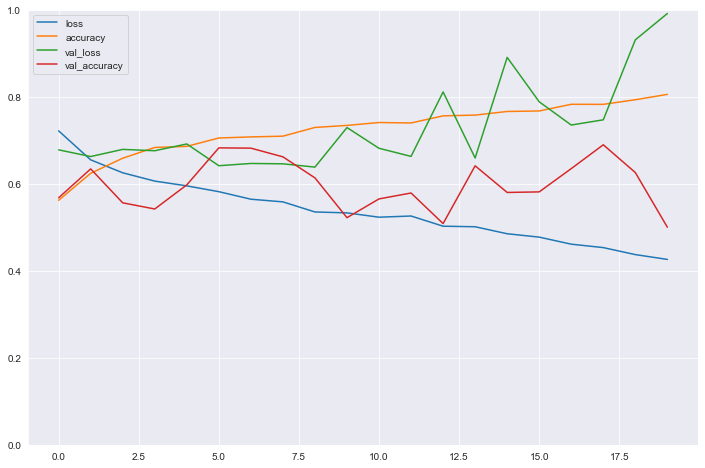

In [48]:
model_eval(history_2)

## Final Model.

In [52]:
model_3 = Sequential()
model_3.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(Dropout(0.1))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_3.add(Flatten())
model_3.add(Dense(units = 128 , activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(units = 1 , activation = 'sigmoid'))
model_3.compile(optimizer = "Adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 38, 38, 64)       

# With data augmentation to prevent overfitting and handling the imbalance in dataset

In [54]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [55]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [56]:
history_3 = model_3.fit(datagen.flow(x_train,y_train, batch_size = 50),
                        epochs = 30 ,
                        validation_data = datagen.flow(x_val, y_val),
                        callbacks = [learning_rate_reduction])

Epoch 1/30
175/175 [==============================] - 418s 2s/step - loss: 0.6787 - accuracy: 0.6994 - val_loss: 0.9698 - val_accuracy: 0.5216
Epoch 2/30
175/175 [==============================] - 411s 2s/step - loss: 0.5581 - accuracy: 0.7205 - val_loss: 0.6635 - val_accuracy: 0.5719
Epoch 3/30
175/175 [==============================] - 403s 2s/step - loss: 0.5495 - accuracy: 0.7309 - val_loss: 0.5762 - val_accuracy: 0.7228
Epoch 4/30
175/175 [==============================] - 399s 2s/step - loss: 0.5224 - accuracy: 0.7428 - val_loss: 0.7311 - val_accuracy: 0.5764
Epoch 5/30
175/175 [==============================] - ETA: 0s - loss: 0.5219 - accuracy: 0.7468
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
175/175 [==============================] - 396s 2s/step - loss: 0.5219 - accuracy: 0.7468 - val_loss: 0.7375 - val_accuracy: 0.5545
Epoch 6/30
175/175 [==============================] - 399s 2s/step - loss: 0.4886 - accuracy: 0.7649 - val_loss: 0.6871 

In [57]:
conv_model_metrics(model_3)

65/65 [==============================] - 13s 203ms/step - loss: 1.2906 - accuracy: 0.4651
Train loss: 72.307%
Train Accuracy 63.942%
Test Loss: 129.057%
Test Accuracy: 46.512%


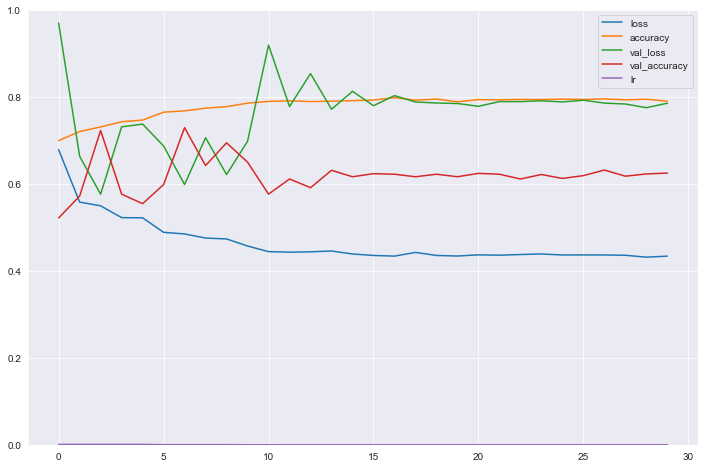

In [58]:
model_eval(history_3)

The best model accuracy represented here was approximately 46%. The model was predicting that an area that had experienced a wildfire was about just as likely to have not experienced a wildfire, and vice-versa. Here you can see in the confusion matrix below, in which 0 represents wildfire areas, and 1 represents non-fire areas, that we have an almost perfect balance between false positives to true positives. 

![confusion_matrix](../reports/visualizations/confusion_matrix_test_best.png)

As I attempted to make the model more and more complex, the model started to classify most images as non-wild fire areas, most likely due to overfitting and overlapping features between the two types of areas. Eventually at some point 50% accuracy was the best intended target. Other more advanced models that I ran for longer epochs and had more finely tuned hyperparameters saw a degredation in accuracy, and soaring rates of validation loss.

This is most likely due to overfitting and overlapping similiarties betweeen areas that have experienced wildfire events and those that have not. It is also likely that there is not enough information available in raw satellite images for the CNN to train on to make an accurate prediction. This problem, and strategies to overcome it is addressed in the [Final ReadMe](https://github.com/ptanner925/wildfire_capstone/blob/main/README.md)